# Modelos: Seq

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../lib')

import math
import random
from bunch import Bunch
import seaborn as sns

import numpy as np
import pandas as pd

import torch
from   torch               import nn, Tensor
import torch.nn.functional as F
from   torch.utils.data    import DataLoader, Subset
from   torch.optim         import SparseAdam, Adam

import pytorch_common.util as pu
from   pytorch_common.modules.fn import Fn
from   pytorch_common.callbacks  import (
    EarlyStop,
    ReduceLROnPlateau,
    Validation,
    SaveBestModel
)
from pytorch_common.callbacks.output import Logger, MetricsPlotter
from pytorch_common.util import (
    set_device_name,
    get_device,
    LoggerBuilder
)

import model as ml

import util as ut

import data.dataset as ds
import data.plot as pl
import data as dt
from data.plot import describe_num_var

import metric as mt
import metric.discretizer as dr

## Setup

In [3]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

In [4]:
pu.set_device_name('gpu')

In [5]:
pu.get_device()

device(type='cuda', index=0)

In [6]:
cpu = torch.device("cpu")

In [7]:
torch.cuda.is_available()

True

In [8]:
torch.__version__

'1.13.1+cu117'

In [9]:
def set_seed(value):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)

In [10]:
set_seed(42)

In [11]:
DATASETS_PATH = '../datasets'

In [12]:
class AccFn(torch.nn.Module):
    def __init__(self, device = pu.get_device()):
        super().__init__()
        self.model_type = 'AccFn'
        self.device     = device

    def forward(self, y_pred, y_true):
        y_pred_probs = F.softmax(y_pred, dim=1)
        y_pred_values = torch.argmax(y_pred, axis=1).abs().to(self.device)
        y_true_values = y_true.to(self.device)

        tp = (y_pred_values == y_true_values).sum().item()

        return tp / y_true_values.size(0)

In [13]:
y_pred = torch.tensor([
    [1.0, 0.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.1, 0.0, 1.0],
])
y_true = torch.tensor([0, 1, 0])

AccFn()(y_pred, y_true)

0.6666666666666666

In [14]:
import torch
import torch.nn.functional as F
import pytorch_common.util as ut

class CrossEntropyLossFn(torch.nn.Module):
    def __init__(self, device = pu.get_device()):
        super().__init__()
        self.model_type = 'CrossEntropyLossFn'
        self.loss       = torch.nn.CrossEntropyLoss().to(device)
        self.device     = device

    def forward(self, y_pred, y_true):
        return self.loss(
            y_pred.to(self.device), 
            y_true.type(torch.LongTensor).to(self.device)
        )

In [15]:
y_pred = torch.tensor([
    [20.0, 0.0, 0.0],
    [0.0, 20.0, 0.0],
    [0.0, 0.0, 20.0],
])
y_true = torch.tensor([0, 1, 2])

CrossEntropyLossFn()(y_pred, y_true)

tensor(0., device='cuda:0')

## Carga de dataset

In [16]:
def to_tensor(obs, device, columns): 
    data = obs[columns]
    if type(data) == pd.DataFrame:
        data = data.values
    return torch.tensor(data).to(device)

features_fn = lambda obs, device: to_tensor(obs, device, ['user_seq', 'movie_seq'])
target_fn   = lambda obs, device: to_tensor(obs, device, ['user_movie_rating'])

dataset = ds.MovieLensTMDBDatasetFactory.from_path(
    transform        = features_fn,
    target_transform = target_fn,
    device           = cpu,
    filter_fn        = lambda df: df[(df['user_movie_rating_year'] >= 1990) & (df['user_movie_rating_year'] <= 2019)]
)

In [17]:
train_set, eval_set = dataset.split_train_eval(split_year=2017)

2023-02-14 15:47:08,568 - INFO - Train: 74.85 % - Test: 8.66 %


Se debe For cada usuario extraer la secuencia de peliculas vistas ordenadas por fecha de calificación.
Cada pelicula puede reprsentarte por un embedding el cual se peude inferir en el entrenamiento o constrruirse mediando features
que definan a la propia pelicula.

In [18]:
def find_movies_count_by_user(df):
    return pd.DataFrame({
       'n_movies': [movie_ids.shape[0] for movie_ids in df.groupby(['user_id']).groups.values()]
    })

df = find_movies_count_by_user(train_set.data)

In [19]:
min_bouund, max_bound = dt.n_iqr_range(df, 'n_movies')
min_bouund, max_bound

(0, 16.0)

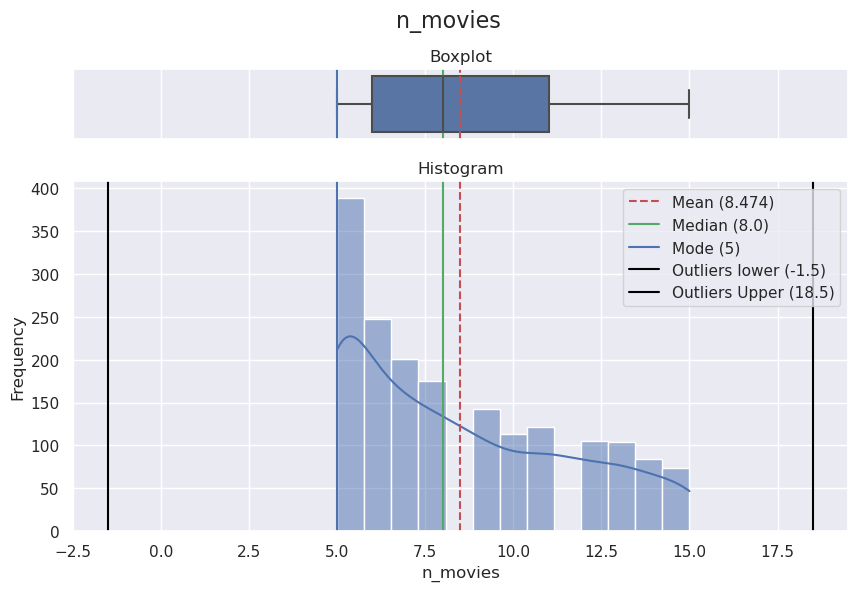

In [20]:
min_input_sequence_dim = 5

df = df[(df['n_movies'] >= min_input_sequence_dim) & (df['n_movies'] < 16)] 
describe_num_var(df, 'n_movies')

In [21]:
params = Bunch(
    epochs               = 60,
    feat_seq_len         = min_input_sequence_dim -1,
    max_input_seq_len    = int(max_bound),
    id_seq_init          = 1,
    batch_size           = 2048,
    n_workers            = 8,
    emb_columns          = ['title', 'genres', 'adults', 'language', 'overview', 'tags', 'year'],
    pre_trained_model    = 'all-MiniLM-L6-v2',
    n_heads              = 8,
    hidden_state_size    = 128,
    n_transformer_layers = 1,
    dropout              = 0.2,
    lr                   = 0.0001,
    padding_emb_position = 0,
    embedding_dim        = None # 100
)

In [22]:
try:
    train_ds = ds.SequenceDataset.load(DATASETS_PATH, 'train')
except:
    train_ds = ds.MovieSequenceDatasetFactory.create(
        train_set,
        feat_seq_len      = params.feat_seq_len,
        id_seq_init       = params.id_seq_init,
        max_movie_seq_len = params.max_input_seq_len,
        n_min             = 20
    )
    train_ds.save(DATASETS_PATH, 'train')
    
try:
    eval_ds = ds.SequenceDataset.load(DATASETS_PATH, 'eval')
except:
    eval_ds = ds.MovieSequenceDatasetFactory.create(
        eval_set,
        feat_seq_len      = params.feat_seq_len,
        id_seq_init       = params.id_seq_init,
        max_movie_seq_len = params.max_input_seq_len,
        train_ds          = train_ds
    )
    eval_ds.save(DATASETS_PATH, 'eval')

train_dl = DataLoader(train_ds, params.batch_size, num_workers=params.n_workers, pin_memory=True, shuffle=True)
eval_dl  = DataLoader(eval_ds,  params.batch_size, num_workers=params.n_workers, pin_memory=True, shuffle=True)

2023-02-14 15:47:09,353 - INFO - group movies by user id
2023-02-14 15:47:09,354 - INFO - get ordered user movie sequences <= 16


Get user movie sequences:   0%|          | 0/149546 [00:00<?, ?it/s]

2023-02-14 15:48:39,408 - INFO - chunk movie sequences with size=4


Filter complete padded:   0%|          | 0/8753 [00:00<?, ?it/s]

Filter target with more han 20 examples:   0%|          | 0/8753 [00:00<?, ?it/s]

2023-02-14 15:48:39,567 - INFO - Excluded: 8659


In [23]:
def get_targets_info(ds):
    data = {}
    for idx, feature in enumerate(ds.features):
        key = str(feature.numpy())
        if key not in data:
            data[key] = set()
        data[key].add(ds.targets[idx].item())

    data = pd.DataFrame(
        [{'seq': k, 'targets': t } for k, t in data.items()]
    )

    data['n_targets'] = data['targets'].apply(lambda x: len(list(x)))
    data['target'] = data['targets'].apply(lambda x: list(x)[0])
    return data
    
    
    
train_target_info = get_targets_info(train_ds)
eval_target_info = get_targets_info(eval_ds)

In [24]:
set(train_target_info['targets'].apply(lambda x: len(list(x))))

{1}

In [25]:
groups = train_target_info.groupby(['seq'])['n_targets'].sum().reset_index().sort_values(['n_targets'], ascending=False)
groups[groups['n_targets'] >= 2]

,seq,n_targets


In [26]:
groups = eval_target_info.groupby(['seq'])['n_targets'].sum().reset_index().sort_values(['n_targets'], ascending=False)
groups[groups['n_targets'] >= 2]

,seq,n_targets


14

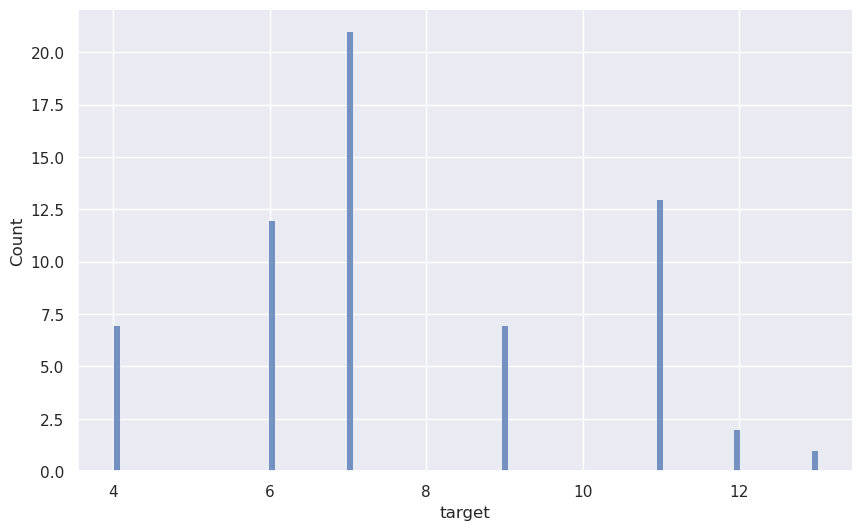

In [27]:
data = pd.DataFrame(
    train_ds.targets.numpy(),
    columns=['target']
)

groups = data['target'].value_counts().reset_index()


groups = groups[groups['target'] >=1]

print(groups.shape[0])

data = data[data['target'].isin(groups.index)]

sns.histplot(data=data, x='target', bins=100)

In [28]:
sequences = [
    [1, 2, 3, 4, 5],
        [1]
]

dt.sequences_to_feats_target(sequences, feat_seq_len=3, padding_value = None)

(array([[1, 2, 3],
       [2, 3, 4]]), array([4, 5]))

In [29]:
emb_generator = ds.MovieEmbeddingGenerator(
  emb_columns            = params.emb_columns,
  pre_trained_model_name = params.pre_trained_model
)

embedding_weights_df = emb_generator(train_set.data)

embedding_weights_df['seq'] = embedding_weights_df['id'].apply(lambda id: train_ds.id_by_seq[id] if id >0 else id)
embedding_weights_df = embedding_weights_df.sort_values(['seq'])

embedding_weights = np.vstack(embedding_weights_df['embedding'])


params.n_classes =  embedding_weights.shape[0] -1

In [30]:
batch = next(iter(train_dl))

Classes count = All embeddings minus padding embedding 

## Model Definition

In [33]:
model = ml.TransformerClasifier(
    embedding_weights,
    sequence_size        = params.feat_seq_len,
    padding_emb_position = params.padding_emb_position,
    nhead                = params.n_heads,
    hidden_state_size    = params.hidden_state_size,
    n_transformer_layers = params.n_transformer_layers,
    dropout              = params.dropout,
    n_classes            = params.n_classes
).to(pu.get_device())

### Model Training

In [34]:
model.fit(
    train_dl,
    epochs      = params.epochs,
    loss_fn     = CrossEntropyLossFn(),
    optimizer   = Adam(
        params = model.parameters(),
        lr     = params.lr
    ),
    callbacks = [
        Validation(
            eval_dl,
            metrics = { 
                'val_acc': AccFn(),
                'val_loss': CrossEntropyLossFn()
            },
            each_n_epochs=1
        ),
        Logger(['time', 'epoch', 'train_loss', 'val_loss', 'val_acc'])
    ]
)

2023-02-14 15:53:26,433 - INFO - {'time': '0:00:00.57', 'epoch': 1, 'train_loss': 9.961747169494629, 'val_loss': tensor(10.0083, device='cuda:0'), 'val_acc': 0.0}
2023-02-14 15:53:26,991 - INFO - {'time': '0:00:00.54', 'epoch': 2, 'train_loss': 9.654837608337402, 'val_loss': tensor(10.0079, device='cuda:0'), 'val_acc': 0.0}
2023-02-14 15:53:27,601 - INFO - {'time': '0:00:00.59', 'epoch': 3, 'train_loss': 9.500218391418457, 'val_loss': tensor(10.0077, device='cuda:0'), 'val_acc': 0.0}
2023-02-14 15:53:28,178 - INFO - {'time': '0:00:00.56', 'epoch': 4, 'train_loss': 9.16474723815918, 'val_loss': tensor(10.0071, device='cuda:0'), 'val_acc': 0.0}
2023-02-14 15:53:28,736 - INFO - {'time': '0:00:00.54', 'epoch': 5, 'train_loss': 8.91798210144043, 'val_loss': tensor(10.0093, device='cuda:0'), 'val_acc': 0.0}
2023-02-14 15:53:29,334 - INFO - {'time': '0:00:00.58', 'epoch': 6, 'train_loss': 8.725157737731934, 'val_loss': tensor(10.0091, device='cuda:0'), 'val_acc': 0.0}
2023-02-14 15:53:29,897 

KeyboardInterrupt: 